In [1]:
# Experiment 3: SHM Function Approximation (A cos(ωt)) using MLP vs KAN
# Styled similar to CNN+KAN notebook: step-based, clear structure, plots included.

# Step 0: Imports, device setup, helpers
import os
import torch
import torch.nn as nn
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

os.environ.pop("MPLBACKEND", None)
import matplotlib

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

def rmse(y, yhat): return torch.sqrt(nn.MSELoss()(yhat, y)).item()
def r2_score_torch(y, yhat): return r2_score(y.cpu().numpy(), yhat.cpu().numpy())

torch.manual_seed(0)

device: mps


Using device: mps
Train: 5000 Test: 1000


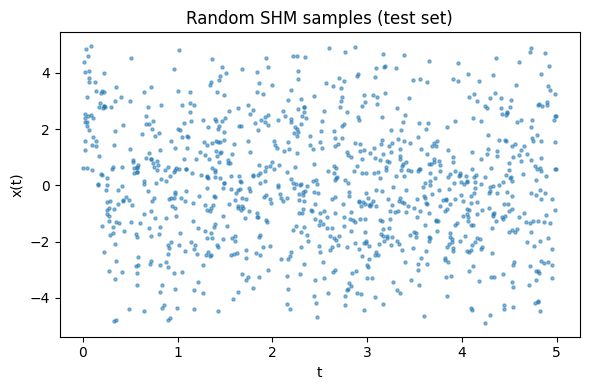

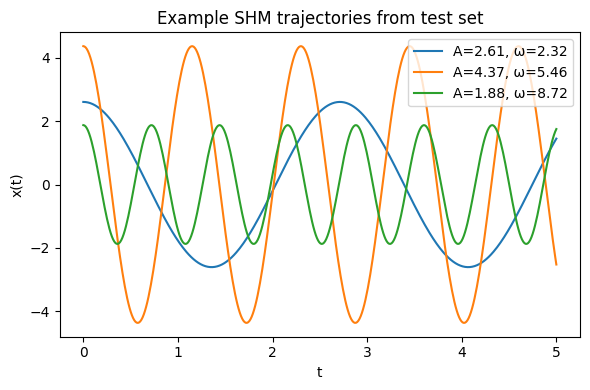

In [2]:
# Genarate Synthetic Data
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

# Step 1: Generate SHM data x(t) = A cos(ωt)
def generate_shm_dataset(n_samples=6000):
    A = torch.empty(n_samples,1).uniform_(0.5,5.0)
    w = torch.empty(n_samples,1).uniform_(0.5,10.0)
    t = torch.empty(n_samples,1).uniform_(0.0,5.0)
    x = A * torch.cos(w*t)
    return A,w,t,x

A,w,t,x = generate_shm_dataset()
idx = torch.randperm(len(x))
train_idx, test_idx = idx[:5000], idx[5000:]

A_tr, w_tr, t_tr, x_tr = A[train_idx], w[train_idx], t[train_idx], x[train_idx]
A_te, w_te, t_te, x_te = A[test_idx], w[test_idx], t[test_idx], x[test_idx]

y_tr, y_te = x_tr.to(device), x_te.to(device)

print("Train:", len(y_tr), "Test:", len(y_te))



# 1) Scatter of (t, x) for a subset of test samples
t_plot = t_te[:1000].cpu().numpy()
x_plot = x_te[:1000].cpu().numpy()

plt.figure(figsize=(6, 4))
plt.scatter(t_plot, x_plot, s=5, alpha=0.5)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Random SHM samples (test set)")
plt.tight_layout()
plt.show()

# 2) Plot full SHM curves for a few individual samples
plt.figure(figsize=(6, 4))

num_examples = 3
t_line = torch.linspace(0, 5, 400).unsqueeze(1)  # dense time for nice curves

for i in range(num_examples):
    A_i = A_te[i]
    w_i = w_te[i]
    x_line = A_i * torch.cos(w_i * t_line)

    plt.plot(
        t_line.cpu().numpy(),
        x_line.cpu().numpy(),
        label=f"A={A_i.item():.2f}, ω={w_i.item():.2f}"
    )

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Example SHM trajectories from test set")
plt.legend()
plt.tight_layout()
plt.show()

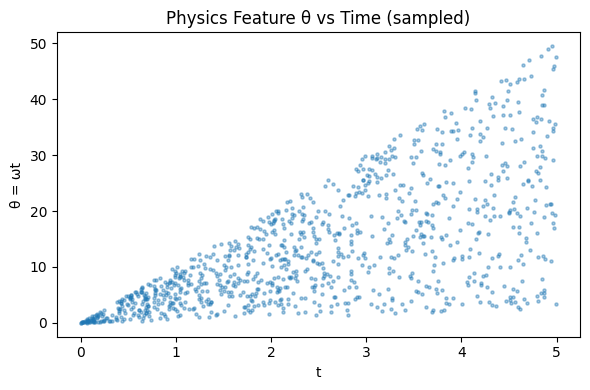

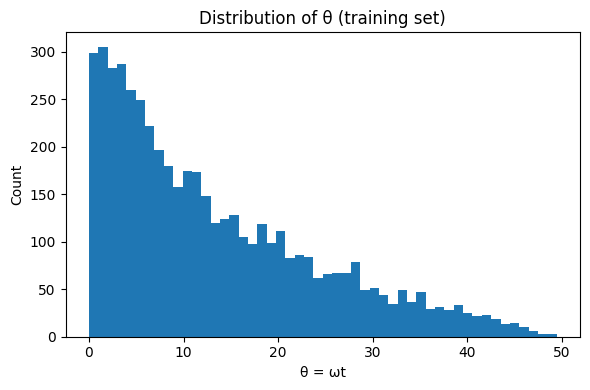

In [3]:
# Step 2: Physics feature θ = ωt + Normalization

theta_tr = (w_tr*t_tr).to(device)
theta_te = (w_te*t_te).to(device)

Xtr_full = torch.cat([A_tr,w_tr,t_tr,theta_tr.cpu()], dim=1).to(device)
Xte_full = torch.cat([A_te,w_te,t_te,theta_te.cpu()], dim=1).to(device)

mean, std = Xtr_full.mean(0,True), Xtr_full.std(0,True)+1e-8
Xtr_full_norm = (Xtr_full-mean)/std
Xte_full_norm = (Xte_full-mean)/std

y_mean, y_std = y_tr.mean(), y_tr.std()+1e-8
y_tr_norm = (y_tr-y_mean)/y_std
y_te_norm = (y_te-y_mean)/y_std

Xtr_mlp, Xte_mlp = Xtr_full_norm, Xte_full_norm
Xtr_aux, Xte_aux = Xtr_full_norm[:,[0,3]], Xte_full_norm[:,[0,3]]
Xtr_raw, Xte_raw = Xtr_full_norm[:,:3], Xte_full_norm[:,:3]

theta_sample = theta_tr[:1000].cpu().numpy()
t_sample = t_tr[:1000].cpu().numpy()

plt.figure(figsize=(6,4))
plt.scatter(t_sample, theta_sample, s=5, alpha=0.4)
plt.xlabel("t")
plt.ylabel("θ = ωt")
plt.title("Physics Feature θ vs Time (sampled)")
plt.tight_layout()
plt.show()

# ===== Distribution of θ (before normalization) =====

plt.figure(figsize=(6,4))
plt.hist(theta_tr.cpu().numpy(), bins=50)
plt.xlabel("θ = ωt")
plt.ylabel("Count")
plt.title("Distribution of θ (training set)")
plt.tight_layout()
plt.show()

[MLP_raw] epoch 50/300 | loss=0.920936
[MLP_raw] epoch 100/300 | loss=0.816908
[MLP_raw] epoch 150/300 | loss=0.709900
[MLP_raw] epoch 200/300 | loss=0.641069
[MLP_raw] epoch 250/300 | loss=0.584762
[MLP_raw] epoch 300/300 | loss=0.548714

MLP_raw RMSE: 1.7298061847686768 R²: 0.37718164920806885


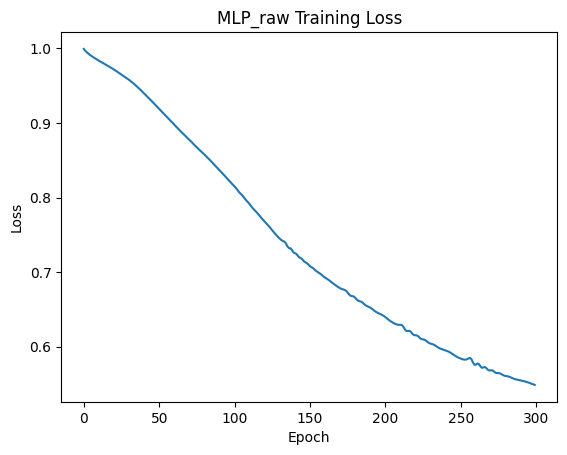

In [4]:
# Step 3A: MLP baseline (raw inputs: A, ω, t)
class MLP_Raw(nn.Module):
    def __init__(self, in_dim=3, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,hidden), nn.ReLU(),
            nn.Linear(hidden,hidden), nn.ReLU(),
            nn.Linear(hidden,hidden), nn.ReLU(),
            nn.Linear(hidden,1)
        )
    def forward(self,x): return self.net(x)

mlp_raw = MLP_Raw().to(device)
opt_raw = torch.optim.AdamW(mlp_raw.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

mlp_raw_losses = []
for ep in range(1,301):
    mlp_raw.train()
    opt_raw.zero_grad()
    yhat = mlp_raw(Xtr_raw)
    loss = loss_fn(yhat, y_tr_norm)
    loss.backward()
    opt_raw.step()
    mlp_raw_losses.append(loss.item())
    if ep % 50 == 0:
        print(f"[MLP_raw] epoch {ep}/300 | loss={loss.item():.6f}")

mlp_raw.eval()
with torch.no_grad():
    pred_norm = mlp_raw(Xte_raw)
    yhat_mlp_raw = pred_norm*y_std + y_mean

mlp_raw_rmse = rmse(y_te, yhat_mlp_raw)
mlp_raw_r2 = r2_score_torch(y_te, yhat_mlp_raw)

print("\nMLP_raw RMSE:", mlp_raw_rmse, "R²:", mlp_raw_r2)

plt.plot(mlp_raw_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP_raw Training Loss")
plt.show()


MLP epoch 50 loss 0.9307182431221008
MLP epoch 100 loss 0.8146365284919739
MLP epoch 150 loss 0.6735414862632751
MLP epoch 200 loss 0.5556132197380066
MLP epoch 250 loss 0.46825140714645386
MLP epoch 300 loss 0.40191367268562317

MLP RMSE: 1.5614491701126099 R2: 0.4925161600112915


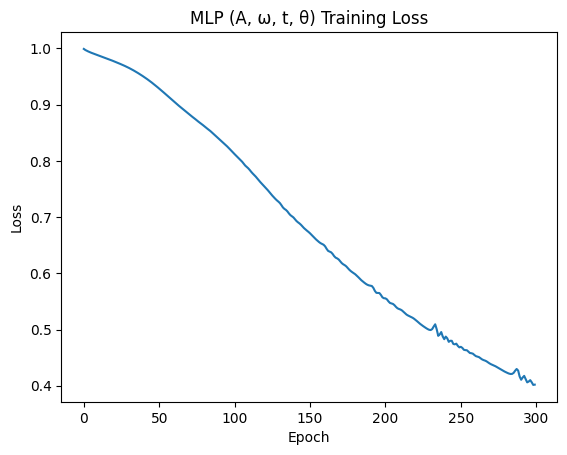

In [5]:
# Step 3B: MLP baseline (4 inputs: A,ω,t,θ)
class MLP(nn.Module):
    def __init__(self, in_dim=4, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,hidden), nn.ReLU(),
            nn.Linear(hidden,hidden), nn.ReLU(),
            nn.Linear(hidden,hidden), nn.ReLU(),
            nn.Linear(hidden,1)
        )
    def forward(self,x): return self.net(x)

mlp = MLP().to(device)
opt_mlp = torch.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

mlp_losses = []
for ep in range(1,301):
    mlp.train()
    opt_mlp.zero_grad()
    yhat = mlp(Xtr_mlp)
    loss = loss_fn(yhat, y_tr_norm)
    loss.backward()
    opt_mlp.step()
    mlp_losses.append(loss.item())
    if ep%50==0: print("MLP epoch",ep,"loss",loss.item())

mlp.eval()
with torch.no_grad():
    pred_norm = mlp(Xte_mlp)
    yhat_mlp = pred_norm*y_std + y_mean

mlp_rmse = rmse(y_te,yhat_mlp)
mlp_r2 = r2_score_torch(y_te,yhat_mlp)

print("\nMLP RMSE:",mlp_rmse,"R2:",mlp_r2)


plt.plot(mlp_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP (A, ω, t, θ) Training Loss")
plt.show()

In [ ]:
# Step 4: Train KAN models (with and without θ)
import kan

try:
    KAN = kan.KAN
except AttributeError:
    try:
        KAN = kan.KAN.KAN
    except AttributeError:
        from kan.MultKAN import MultKAN as KAN



kan_aux = KAN(width=[2,64,64,1], grid=7, k=3, seed=0, device=device)
dataset_aux = {"train_input":Xtr_aux,"train_label":y_tr_norm,"test_input":Xte_aux,"test_label":y_te_norm}


kan_aux.fit(dataset_aux,opt="LBFGS",steps=150, update_grid=False)
with torch.no_grad():
    yhat_aux_norm = kan_aux(Xte_aux)
    yhat_aux = yhat_aux_norm*y_std+y_mean
aux_rmse = rmse(y_te,yhat_aux)
aux_r2 = r2_score_torch(y_te,yhat_aux)

kan_raw = KAN(width=[3,64,64,1], grid=7, k=3, seed=0, device=device)
dataset_raw = {"train_input":Xtr_raw,"train_label":y_tr_norm,"test_input":Xte_raw,"test_label":y_te_norm}
kan_raw.fit(dataset_raw,opt="LBFGS",steps=150, update_grid=False)
with torch.no_grad():
    yhat_raw_norm = kan_raw(Xte_raw)
    yhat_raw = yhat_raw_norm*y_std+y_mean
raw_rmse = rmse(y_te,yhat_raw)
raw_r2 = r2_score_torch(y_te,yhat_raw)

print("\nKAN θ RMSE:",aux_rmse,"R2:",aux_r2)
print("KAN raw RMSE:",raw_rmse,"R2:",raw_r2)



checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.03e-03 | test_loss: 8.72e-03 | reg: 2.18e+02 | : 100%|█| 150/150 [05:14<00:00,  2.10


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-02 | test_loss: 5.98e-02 | reg: 2.47e+02 | : 100%|█| 150/150 [05:09<00:00,  2.06


saving model version 0.1

KAN θ RMSE: 0.01868421770632267 R2: 0.9999273419380188
KAN raw RMSE: 0.12800602614879608 R2: 0.9965894222259521


AttributeError: 'float' object has no attribute 'item'

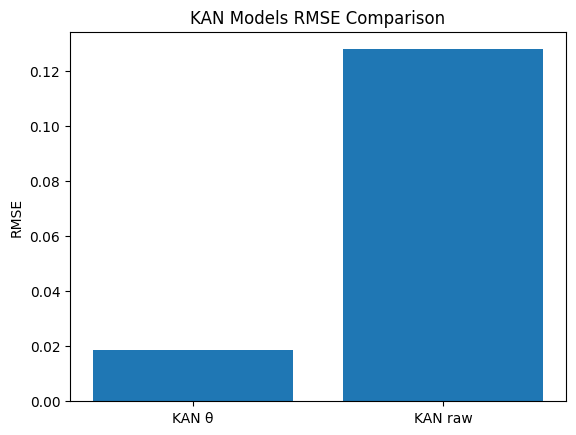

In [8]:
models = ["KAN θ", "KAN raw"]
rmses = [float(aux_rmse), float(raw_rmse)]

plt.bar(models, rmses)
plt.ylabel("RMSE")
plt.title("KAN Models RMSE Comparison")
plt.show()

In [ ]:
# 
# Step 5: Plots

import matplotlib.pyplot as plt
matplotlib.use("module://matplotlib_inline.backend_inline")  # Jupyter inline backend

# ---- Scatter plots: True vs Predicted ----
plt.figure(figsize=(4,4))
plt.scatter(y_te.cpu(), yhat_mlp.cpu(), s=4, alpha=0.4)
plt.xlabel("True x(t)"); plt.ylabel("MLP Prediction")
plt.title("MLP: True vs Predicted")
plt.grid(True); plt.tight_layout()
plt.savefig("mlp_scatter.png",dpi=200)

plt.figure(figsize=(4,4))

plt.scatter(y_te.cpu(), yhat_aux.cpu(), s=4, alpha=0.4, color="green")
plt.xlabel("True x(t)"); plt.ylabel("KAN θ Prediction")
plt.title("KAN (with θ): True vs Predicted")
plt.grid(True); plt.tight_layout()
plt.savefig("kan_theta_scatter.png",dpi=200)

plt.figure(figsize=(4,4))
plt.scatter(y_te.cpu(), yhat_raw.cpu(), s=4, alpha=0.4, color="orange")
plt.xlabel("True x(t)"); plt.ylabel("KAN raw Prediction")
plt.title("KAN (raw): True vs Predicted")
plt.grid(True); plt.tight_layout()
plt.savefig("kan_raw_scatter.png",dpi=200)



Done. Plots saved.


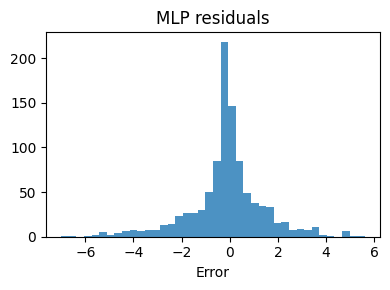

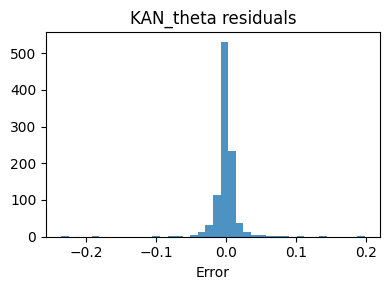

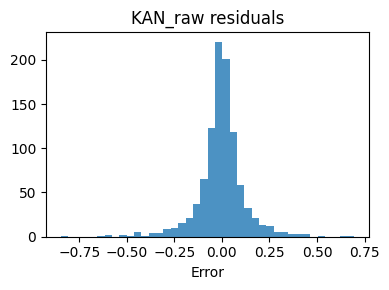

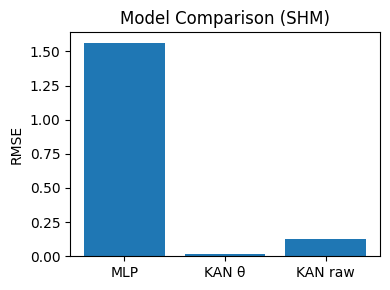

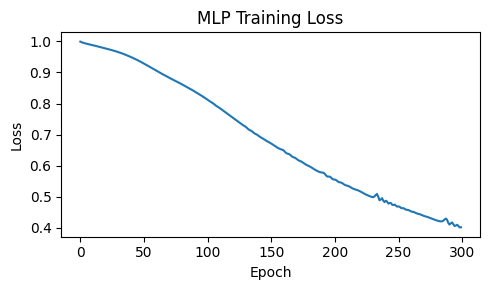

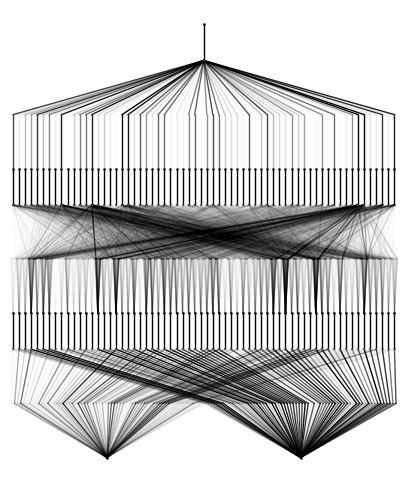

In [9]:
# ---- Histograms of residuals ----
def residuals_plot(true, pred, name):
    res = (pred - true).cpu().numpy()
    plt.figure(figsize=(4,3))
    plt.hist(res, bins=40, alpha=0.8)
    plt.title(name + " residuals")
    plt.xlabel("Error"); plt.tight_layout()
    plt.savefig(name+"_residuals.png",dpi=200)

residuals_plot(y_te, yhat_mlp, "MLP")
residuals_plot(y_te, yhat_aux, "KAN_theta")
residuals_plot(y_te, yhat_raw, "KAN_raw")

# ---- Bar chart of RMSE ----
labels = ["MLP","KAN θ","KAN raw"]
vals = [mlp_rmse, aux_rmse, raw_rmse]
plt.figure(figsize=(4,3))
plt.bar(labels, vals); plt.ylabel("RMSE")
plt.title("Model Comparison (SHM)")
plt.tight_layout(); plt.savefig("rmse_bar.png",dpi=200)

# ---- Loss curve ----
plt.figure(figsize=(5,3))
plt.plot(mlp_losses)
plt.title("MLP Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.tight_layout(); plt.savefig("mlp_loss_curve.png",dpi=200)

# ---- Optional: KAN internal plot ----
try:
    _ = kan_aux(Xte_aux)
    kan_aux.plot()
    plt.savefig("kan_theta_internal_plot.png",dpi=200)
except:
    pass

print("\nDone. Plots saved.")